<a href="https://colab.research.google.com/github/magda-r/nlp-covid19/blob/master/notebooks/nlp_covid19_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 - Tweets' EDA and Pre-processing

This notebook contains EDA (Exploratory Data Analysis) for COVID-19 related tweets organized according ot the following steps:

1. Context and datset info    
2. Imports and loading data
3. Covid situation worldwide
4. Basic EDA and text prep
    - Lowercase
    - Punctuations  
    - Tokenization
    - Stopwords
    - Stemming and Lemmatization
    - Word Clouds
    - Bigrams and Trigrams
    - Text Networks
    - Emojis
5. Saving the output file

### 1. Context and datset info

Dataset consists of 426,426 tweets exctacted using Tweepy (with developer access, tweets up to 7 days old) and snscraper (tweets older than 7 days) libraries with Twitter API.  

Applied filters:
- timeframes: 2020-03-01 - 2021-04-30 (maximum 1000 tweets per day)  
- query keywords: covid, coronavirus, corona, pandemic, vaccine, vaccinated, lockdown, quarantine 
- retweets and replies excluded
- only English language included 

### 2. Imports and loading data


In [162]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk import bigrams, ngrams, everygrams 
import itertools
import collections
import networkx as nx

import string
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

import emoji
sns.set_theme()
pd.set_option('mode.chained_assignment', None)

In [47]:
tweets_df = pd.read_csv('../data/covid19_tweets_snscrape_daily.csv')
covid_df = pd.read_csv('../data/owid-covid-data.csv')

In [48]:
tweets_df.head()

id                                               text  \
0  1234267171276099588  #travelbannow\n#Coronavirus outbreak fears cau...   
1  1234267168843403266  It was said that once the president declared i...   
2  1234267164229734401  Postal worker tests positive for coronavirus -...   
3  1234267161855590400  Coronavirus discovered in Moscow\nMilan Connec...   
4  1234267155941789698  Coronavirus: Pence defends Trump Jr claim Demo...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2020-03-01 23:59:59+00:00           0            0         1   
1  2020-03-01 23:59:59+00:00           0            0         4   
2  2020-03-01 23:59:58+00:00           0            0         0   
3  2020-03-01 23:59:57+00:00           0            2         2   
4  2020-03-01 23:59:56+00:00           0            0         0   

                user                   location  no_followers  
0     GreenMtnBoy359                14th State            194  
1    John D. Pieratt  Austin - Giddings, Texas.         11985  
2   Brazenly🐕Liberal             Back of Beyond          1605  
3  Elisa E. H.❤에리사벳타                         CA           232  
4  Baby to Boomer LS            Near Seattle WA         18104

In [49]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426426 entries, 0 to 426425
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            426426 non-null  int64 
 1   text          426426 non-null  object
 2   datetime      426426 non-null  object
 3   no_replies    426426 non-null  int64 
 4   no_retweets   426426 non-null  int64 
 5   no_likes      426426 non-null  int64 
 6   user          426391 non-null  object
 7   location      320335 non-null  object
 8   no_followers  426426 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 29.3+ MB


In [50]:
tweets_df.iloc[0,1]

"#travelbannow\n#Coronavirus outbreak fears cause @Delta Airlines to suspend all flights to Milan from New Yorks's JFK starting tomorrow https://t.co/hodle6ISND"

In [51]:
tweets_df.iloc[1,1]

'It was said that once the president declared it a pandemic that all testing is free. https://t.co/xcKsGOMxuu'

In [52]:
tweets_df.iloc[2,1]

'Postal worker tests positive for coronavirus - ABC News https://t.co/XccH0sk1lc (via @ABC)'

### 3. Covid situation worldwide


In [53]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98432 entries, 0 to 98431
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               98432 non-null  object 
 1   continent                              93808 non-null  object 
 2   location                               98432 non-null  object 
 3   date                                   98432 non-null  object 
 4   total_cases                            94976 non-null  float64
 5   new_cases                              94973 non-null  float64
 6   new_cases_smoothed                     93963 non-null  float64
 7   total_deaths                           84879 non-null  float64
 8   new_deaths                             85035 non-null  float64
 9   new_deaths_smoothed                    93963 non-null  float64
 10  total_cases_per_million                94470 non-null  float64
 11  ne

In [54]:
covid_df = covid_df.loc[(covid_df['date'] >= '2020-03-01') & (covid_df['date'] <= '2021-04-30')]
covid_df.head()

iso_code continent     location        date  total_cases  new_cases  \
6       AFG      Asia  Afghanistan  2020-03-01          1.0        0.0   
7       AFG      Asia  Afghanistan  2020-03-02          1.0        0.0   
8       AFG      Asia  Afghanistan  2020-03-03          2.0        1.0   
9       AFG      Asia  Afghanistan  2020-03-04          4.0        2.0   
10      AFG      Asia  Afghanistan  2020-03-05          4.0        0.0   

    new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
6                0.143           NaN         NaN                  0.0  ...   
7                0.000           NaN         NaN                  0.0  ...   
8                0.143           NaN         NaN                  0.0  ...   
9                0.429           NaN         NaN                  0.0  ...   
10               0.429           NaN         NaN                  0.0  ...   

    extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
6               NaN                597.029                 9.59   
7               NaN                597.029                 9.59   
8               NaN                597.029                 9.59   
9               NaN                597.029                 9.59   
10              NaN                597.029                 9.59   

    female_smokers  male_smokers  handwashing_facilities  \
6              NaN           NaN                  37.746   
7              NaN           NaN                  37.746   
8              NaN           NaN                  37.746   
9              NaN           NaN                  37.746   
10             NaN           NaN                  37.746   

    hospital_beds_per_thousand  life_expectancy  human_development_index  \
6                          0.5            64.83                    0.511   
7                          0.5            64.83                    0.511   
8                          0.5            64.83                    0.511   
9                          0.5            64.83                    0.511   
10                         0.5            64.83                    0.511   

    excess_mortality  
6                NaN  
7                NaN  
8                NaN  
9                NaN  
10               NaN  

[5 rows x 60 columns]

In [55]:
# covid_worldwide = covid_df[['date', 'total_cases', 'total_deaths', 'total_tests', 'people_vaccinated']].groupby('date').sum()
covid_worldwide = covid_df[['date', 'new_cases', 'new_deaths', 'new_tests', 'new_vaccinations']].groupby('date').sum()
covid_worldwide = covid_worldwide.reset_index()
covid_worldwide = pd.melt(covid_worldwide, id_vars="date", var_name='type', value_name='value')

fig = px.line(covid_worldwide, x="date", y="value", color='type', title="Reported data in time")
fig.show()

In [56]:
# countries with highest death ratio
covid_top_countires = covid_df.loc[covid_df['date'] == '2021-04-30']
covid_top_countires = covid_top_countires[['location', 'total_deaths_per_million']].drop_duplicates().sort_values('total_deaths_per_million', ascending=False).reset_index(drop=True)

display(covid_top_countires.head(15))
countries_list = covid_top_countires.iloc[0:15,0].tolist() 

location  total_deaths_per_million
0                     Peru                  5055.859
1                  Hungary                  2850.828
2                  Czechia                  2732.940
3               San Marino                  2651.895
4   Bosnia and Herzegovina                  2606.365
5               Montenegro                  2380.338
6                 Bulgaria                  2360.096
7          North Macedonia                  2330.348
8                 Slovakia                  2140.067
9                  Belgium                  2090.665
10                Slovenia                  2044.319
11                   Italy                  1998.071
12                  Brazil                  1899.615
13          United Kingdom                  1882.199
14           South America                  1805.273

In [57]:
fig = px.line(covid_df.loc[covid_df['location'].isin(countries_list)], x="date", y="total_deaths_per_million", color='location', title="Reported data in time")
fig.show()

In [58]:
fig = px.line(covid_df.loc[covid_df['location'].isin(countries_list)], x="date", y="new_deaths_per_million", color='location', title="Reported data in time")
fig.show()

### 4. Basic EDA and text prep


Text(0.5, 1.0, 'Number of Tweets per location (top 15)')

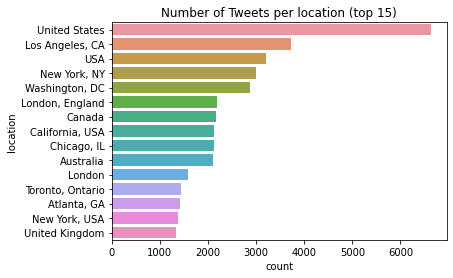

In [59]:
sns.countplot(y="location", data=tweets_df, order=tweets_df.location.value_counts().iloc[:15].index).set_title('Number of Tweets per location (top 15)')

In [60]:
# # number of followers retweets replies and likes
# tweets_df_stats = pd.melt(tweets_df, id_vars='id', value_vars=['no_followers', 'no_retweets', 'no_replies', 'no_likes'], var_name='type', value_name='value')

# fig = px.histogram(tweets_df_stats, 
#                     x="value", 
#                     color="type", 
#                     marginal="rug", # box violin
#                     hover_data=tweets_df_stats.columns)
# fig.show()

#### Text pre-processing

In [61]:
# List of punctations to be removed (# and @ might be reconsidered)
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [144]:
# Setting up stopwords list
stopwords = set(STOPWORDS)
# excluding keywords used in query (collection words)
stopwords.update(['covid', 'covid19', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine',      'vaccinated', 'lockdown', 'quarantine'])
# excluding a couple more irrelevant ones
stopwords.update(['', 'u', 's', 'm', 've', 't', 'don', 're'])

In [145]:
df = tweets_df[['text']]
df.head()

text
0  #travelbannow\n#Coronavirus outbreak fears cau...
1  It was said that once the president declared i...
2  Postal worker tests positive for coronavirus -...
3  Coronavirus discovered in Moscow\nMilan Connec...
4  Coronavirus: Pence defends Trump Jr claim Demo...

In [146]:
# Cleaning functions - 1st stage
def clean_text(text):
    
    # lowercase
    text_lc = text.lower()
    
    # remove URL part 
    text_url = text_lc.split(' https')[0]
    # url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # text_url = url_pattern.sub(r'', text_lc)

    # remove punctation
    text_punc = "".join([word for word in text_url if word not in string.punctuation]) 
    text_punc = re.sub('[0-9]+', '', text_punc)
    return text_punc

In [147]:
df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

text  \
0  #travelbannow\n#Coronavirus outbreak fears cau...   
1  It was said that once the president declared i...   
2  Postal worker tests positive for coronavirus -...   
3  Coronavirus discovered in Moscow\nMilan Connec...   
4  Coronavirus: Pence defends Trump Jr claim Demo...   
5  The coronavirus has likely already dealt many ...   
6  Qatar confirms two more coronavirus cases: Liv...   
7  Your #coronavirus questions answered with Dr. ...   
8  It’s a very intentional thing to say the first...   
9  Blaming low wage wrkrs for the spread of the c...   

                                          text_clean  
0  travelbannow\ncoronavirus outbreak fears cause...  
1  it was said that once the president declared i...  
2  postal worker tests positive for coronavirus  ...  
3  coronavirus discovered in moscow\nmilan connec...  
4  coronavirus pence defends trump jr claim democ...  
5  the coronavirus has likely already dealt many ...  
6  qatar confirms two more coronavirus cases live...  
7  your coronavirus questions answered with dr ma...  
8  it’s a very intentional thing to say the first...  
9  blaming low wage wrkrs for the spread of the c...

In [148]:
# Cleaning functions - 2nd stage
# Tokenization, stopwords, stemming or lemmatization 
def stem_lem_split(text, method='stem'):
    # tokenization
    tokens = re.split('\W+', text)

    # remove stopwords
    text_s = [word for word in tokens if word not in stopwords]
    
    if method=='stem':
        # stemming
        ps = nltk.PorterStemmer()
        text_stem = [ps.stem(word) for word in text_s] 
        return text_stem

    elif method=='lem':
        # lemmatization
        wn = nltk.WordNetLemmatizer()
        text_lem = [wn.lemmatize(word) for word in text_s]
        return text_lem
    else:
        print('Invalid method')

In [149]:
df['text_stem'] = df['text_clean'].apply(lambda x: stem_lem_split(x, method='stem'))
df['text_lem'] = df['text_clean'].apply(lambda x: stem_lem_split(x, method='lem'))

df.head(10)

text  \
0  #travelbannow\n#Coronavirus outbreak fears cau...   
1  It was said that once the president declared i...   
2  Postal worker tests positive for coronavirus -...   
3  Coronavirus discovered in Moscow\nMilan Connec...   
4  Coronavirus: Pence defends Trump Jr claim Demo...   
5  The coronavirus has likely already dealt many ...   
6  Qatar confirms two more coronavirus cases: Liv...   
7  Your #coronavirus questions answered with Dr. ...   
8  It’s a very intentional thing to say the first...   
9  Blaming low wage wrkrs for the spread of the c...   

                                          text_clean  \
0  travelbannow\ncoronavirus outbreak fears cause...   
1  it was said that once the president declared i...   
2  postal worker tests positive for coronavirus  ...   
3  coronavirus discovered in moscow\nmilan connec...   
4  coronavirus pence defends trump jr claim democ...   
5  the coronavirus has likely already dealt many ...   
6  qatar confirms two more coronavirus cases live...   
7  your coronavirus questions answered with dr ma...   
8  it’s a very intentional thing to say the first...   
9  blaming low wage wrkrs for the spread of the c...   

                                           text_stem  \
0  [travelbannow, outbreak, fear, caus, delta, ai...   
1                 [said, presid, declar, test, free]   
2           [postal, worker, test, posit, abc, news]   
3          [discov, moscow, milan, connect, lookner]   
4  [penc, defend, trump, jr, claim, democrat, wan...   
5  [like, alreadi, dealt, mani, econom, blow, now...   
6   [qatar, confirm, two, case, live, updat, ajenew]   
7  [question, answer, dr, maiamajumd, novel, comp...   
8  [intent, thing, say, first, case, confirm, ire...   
9  [blame, low, wage, wrkr, spread, coronavirusco...   

                                            text_lem  
0  [travelbannow, outbreak, fear, cause, delta, a...  
1         [said, president, declared, testing, free]  
2        [postal, worker, test, positive, abc, news]  
3   [discovered, moscow, milan, connection, lookner]  
4  [penny, defends, trump, jr, claim, democrat, w...  
5  [likely, already, dealt, many, economic, blow,...  
6  [qatar, confirms, two, case, live, update, aje...  
7  [question, answered, dr, maiamajumder, novel, ...  
8  [intentional, thing, say, first, case, confirm...  
9  [blaming, low, wage, wrkrs, spread, coronaviru...

#### Word Clouds


In [150]:
string = pd.Series(df['text_clean']).str.cat(sep=' ')

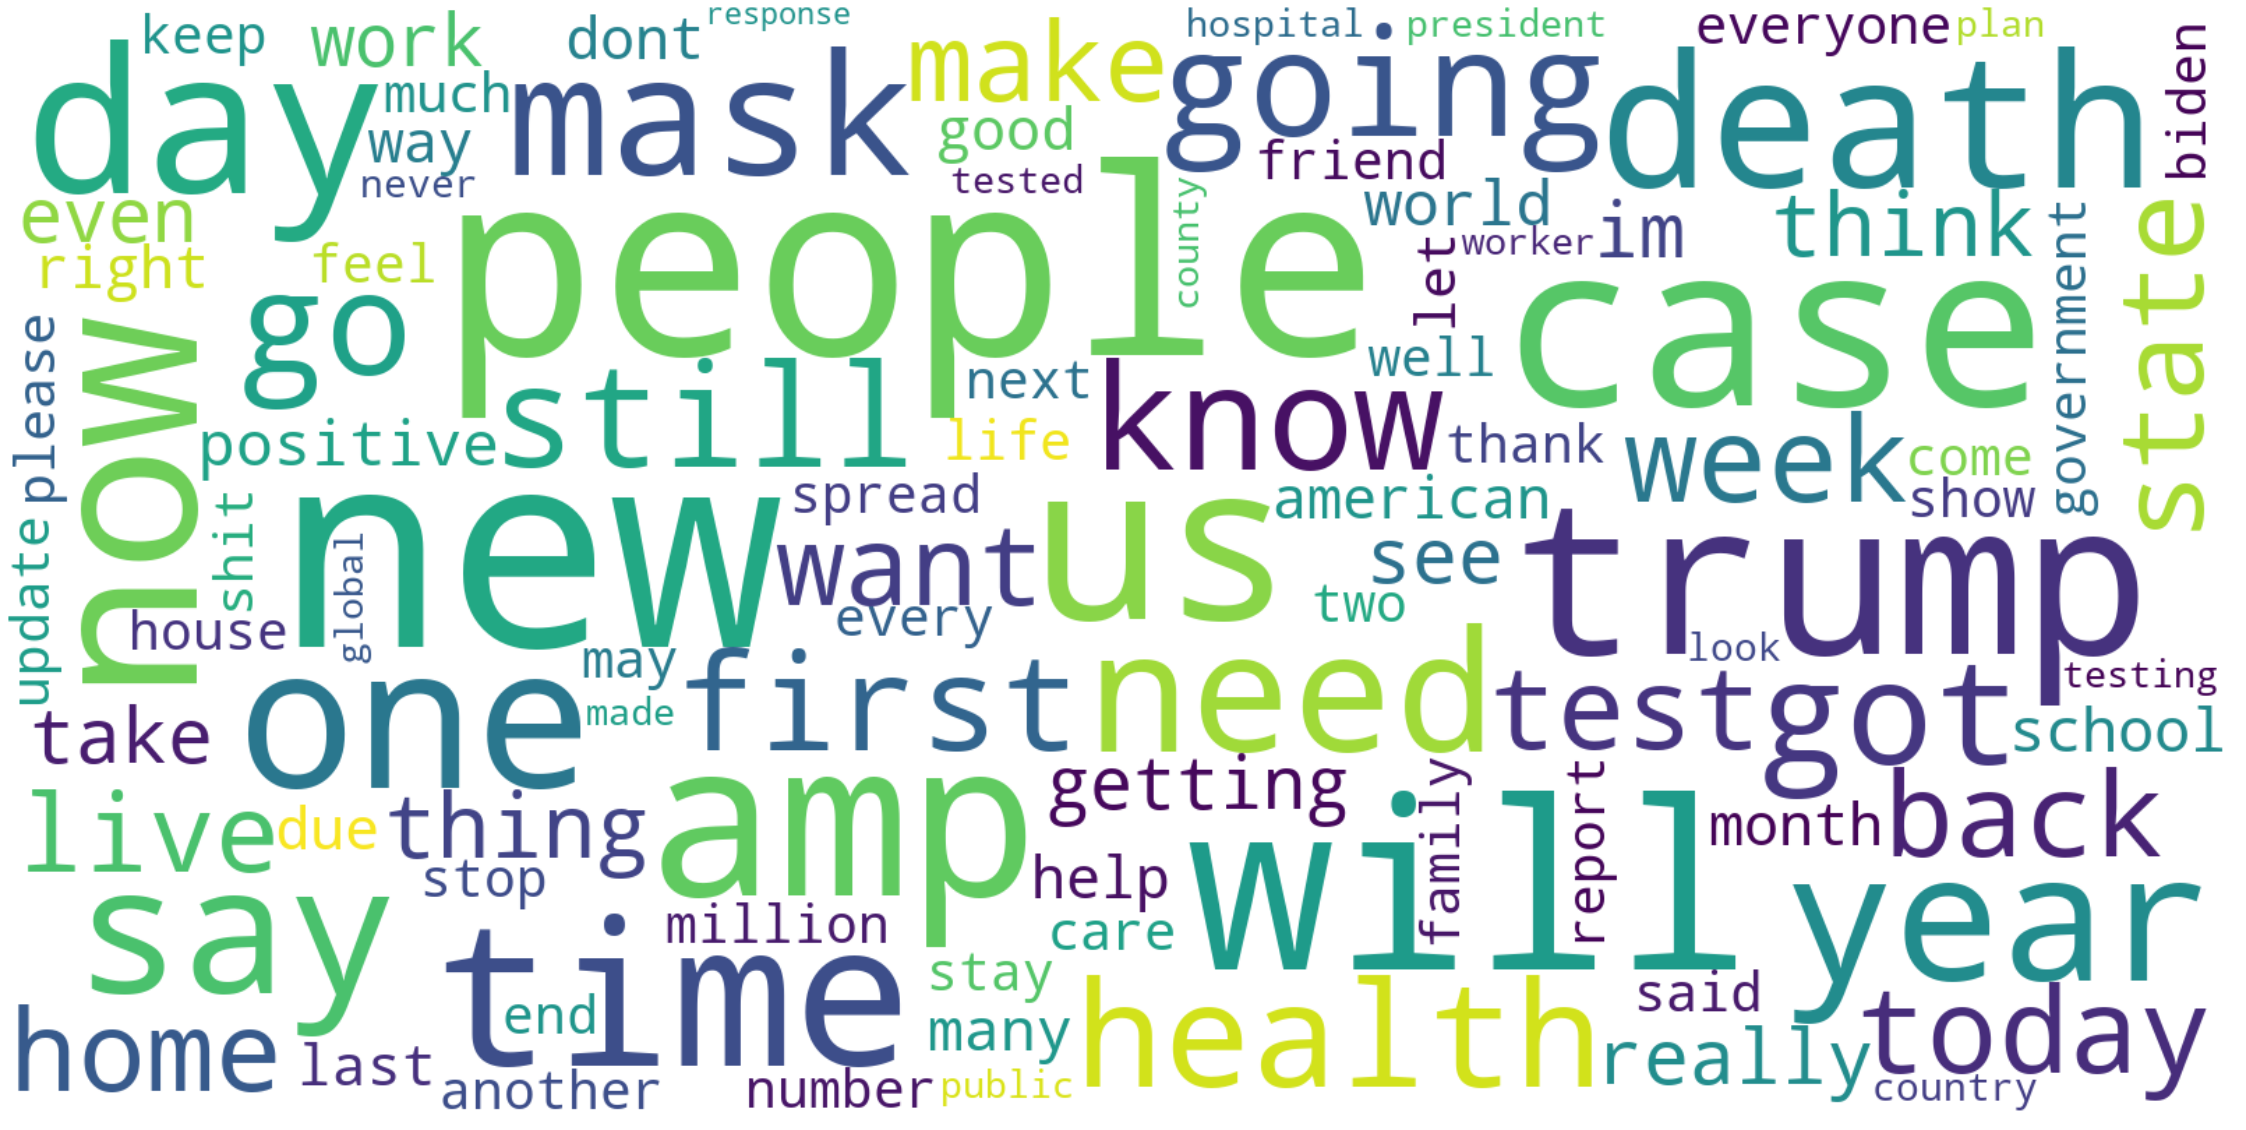

In [151]:
# Word Cloud before stemming/lemmatization
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

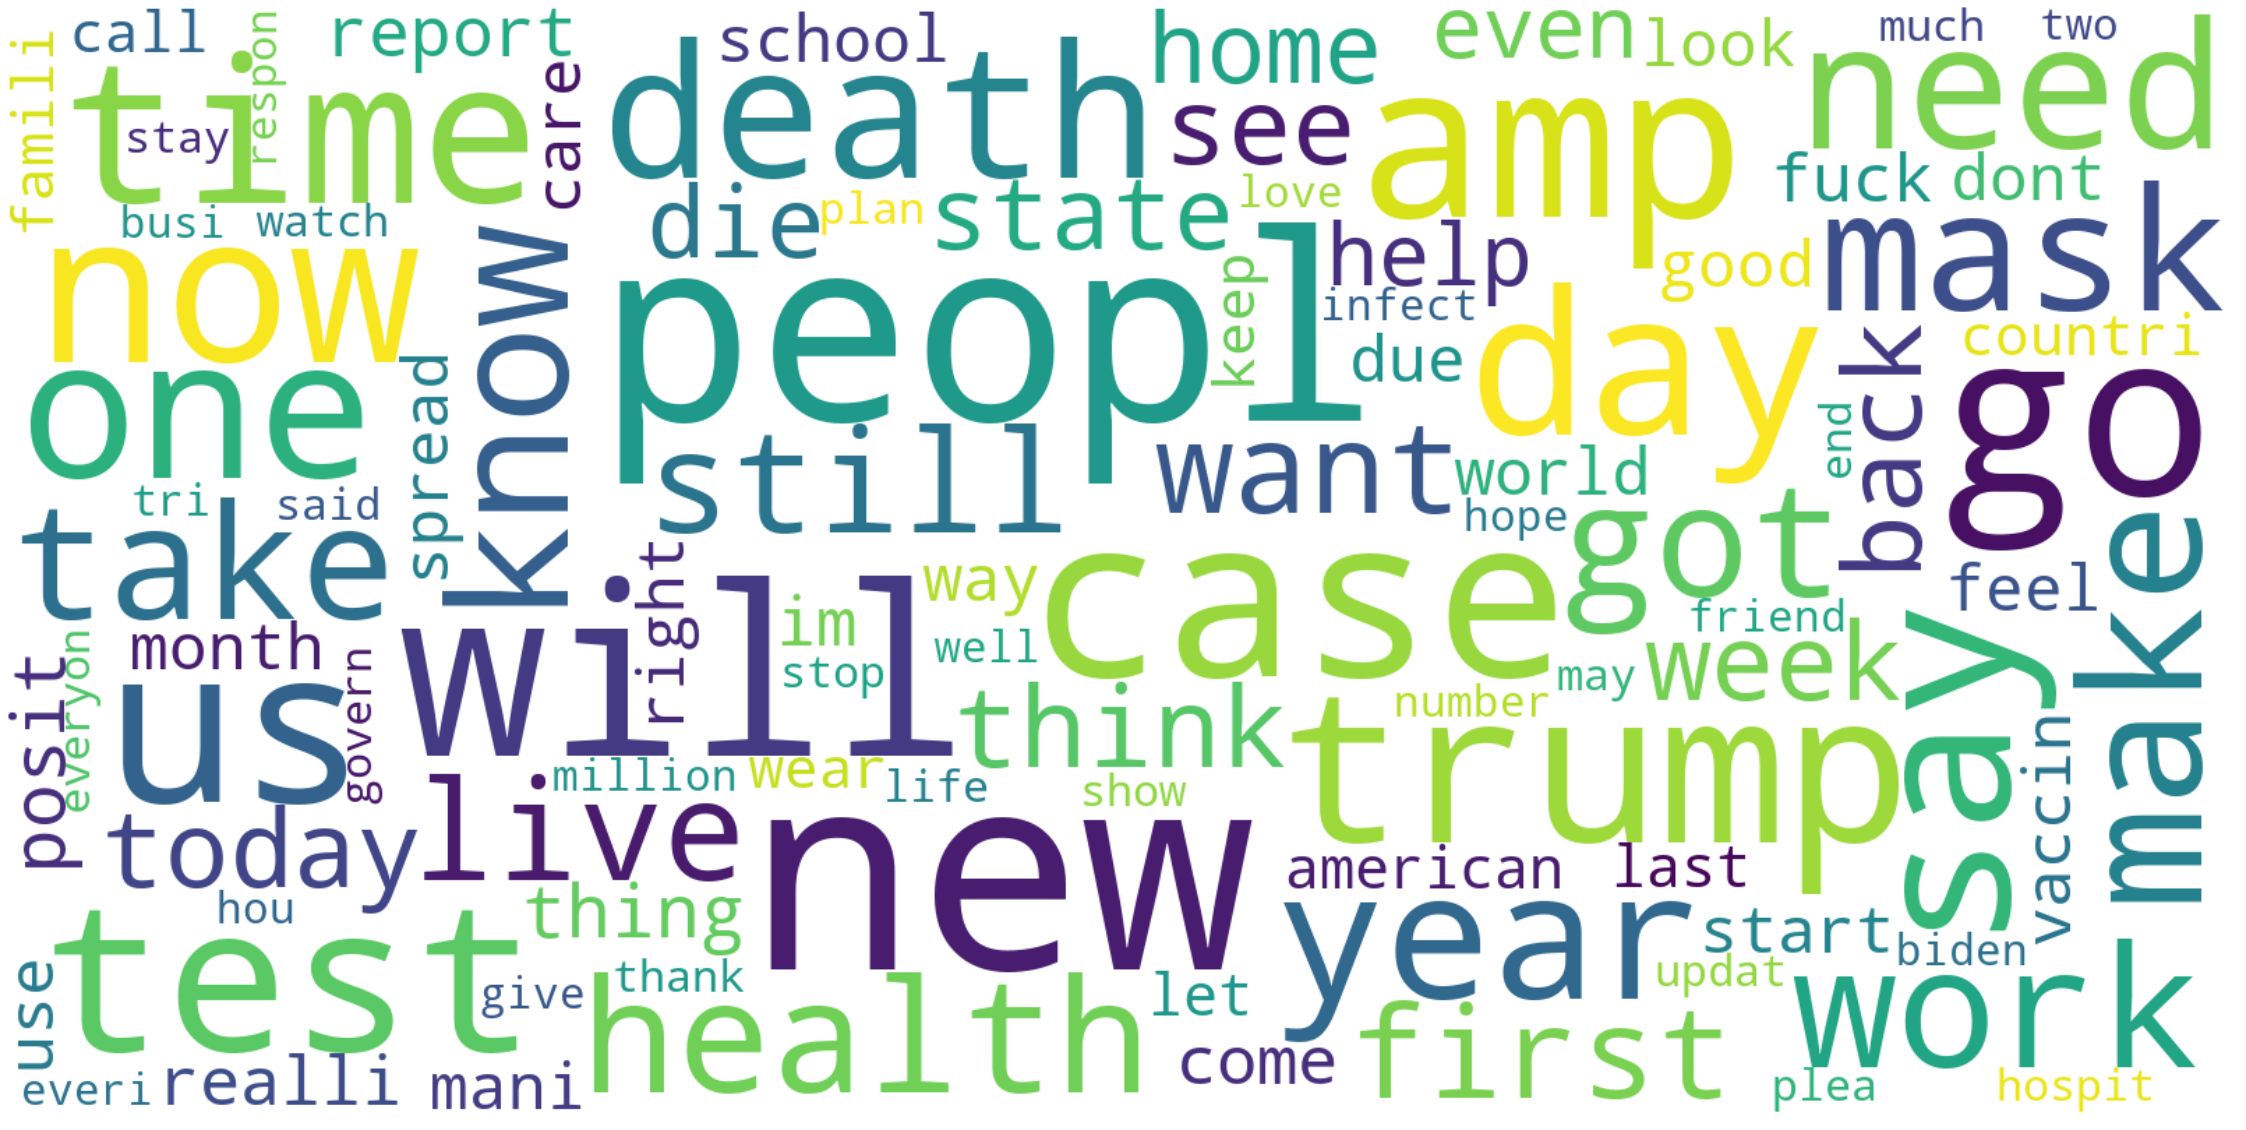

In [152]:
# Word Cloud after stemming
string_stem = df['text_stem'].apply(lambda x: " ".join(x))
string_stem = pd.Series(string_stem).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_stem)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

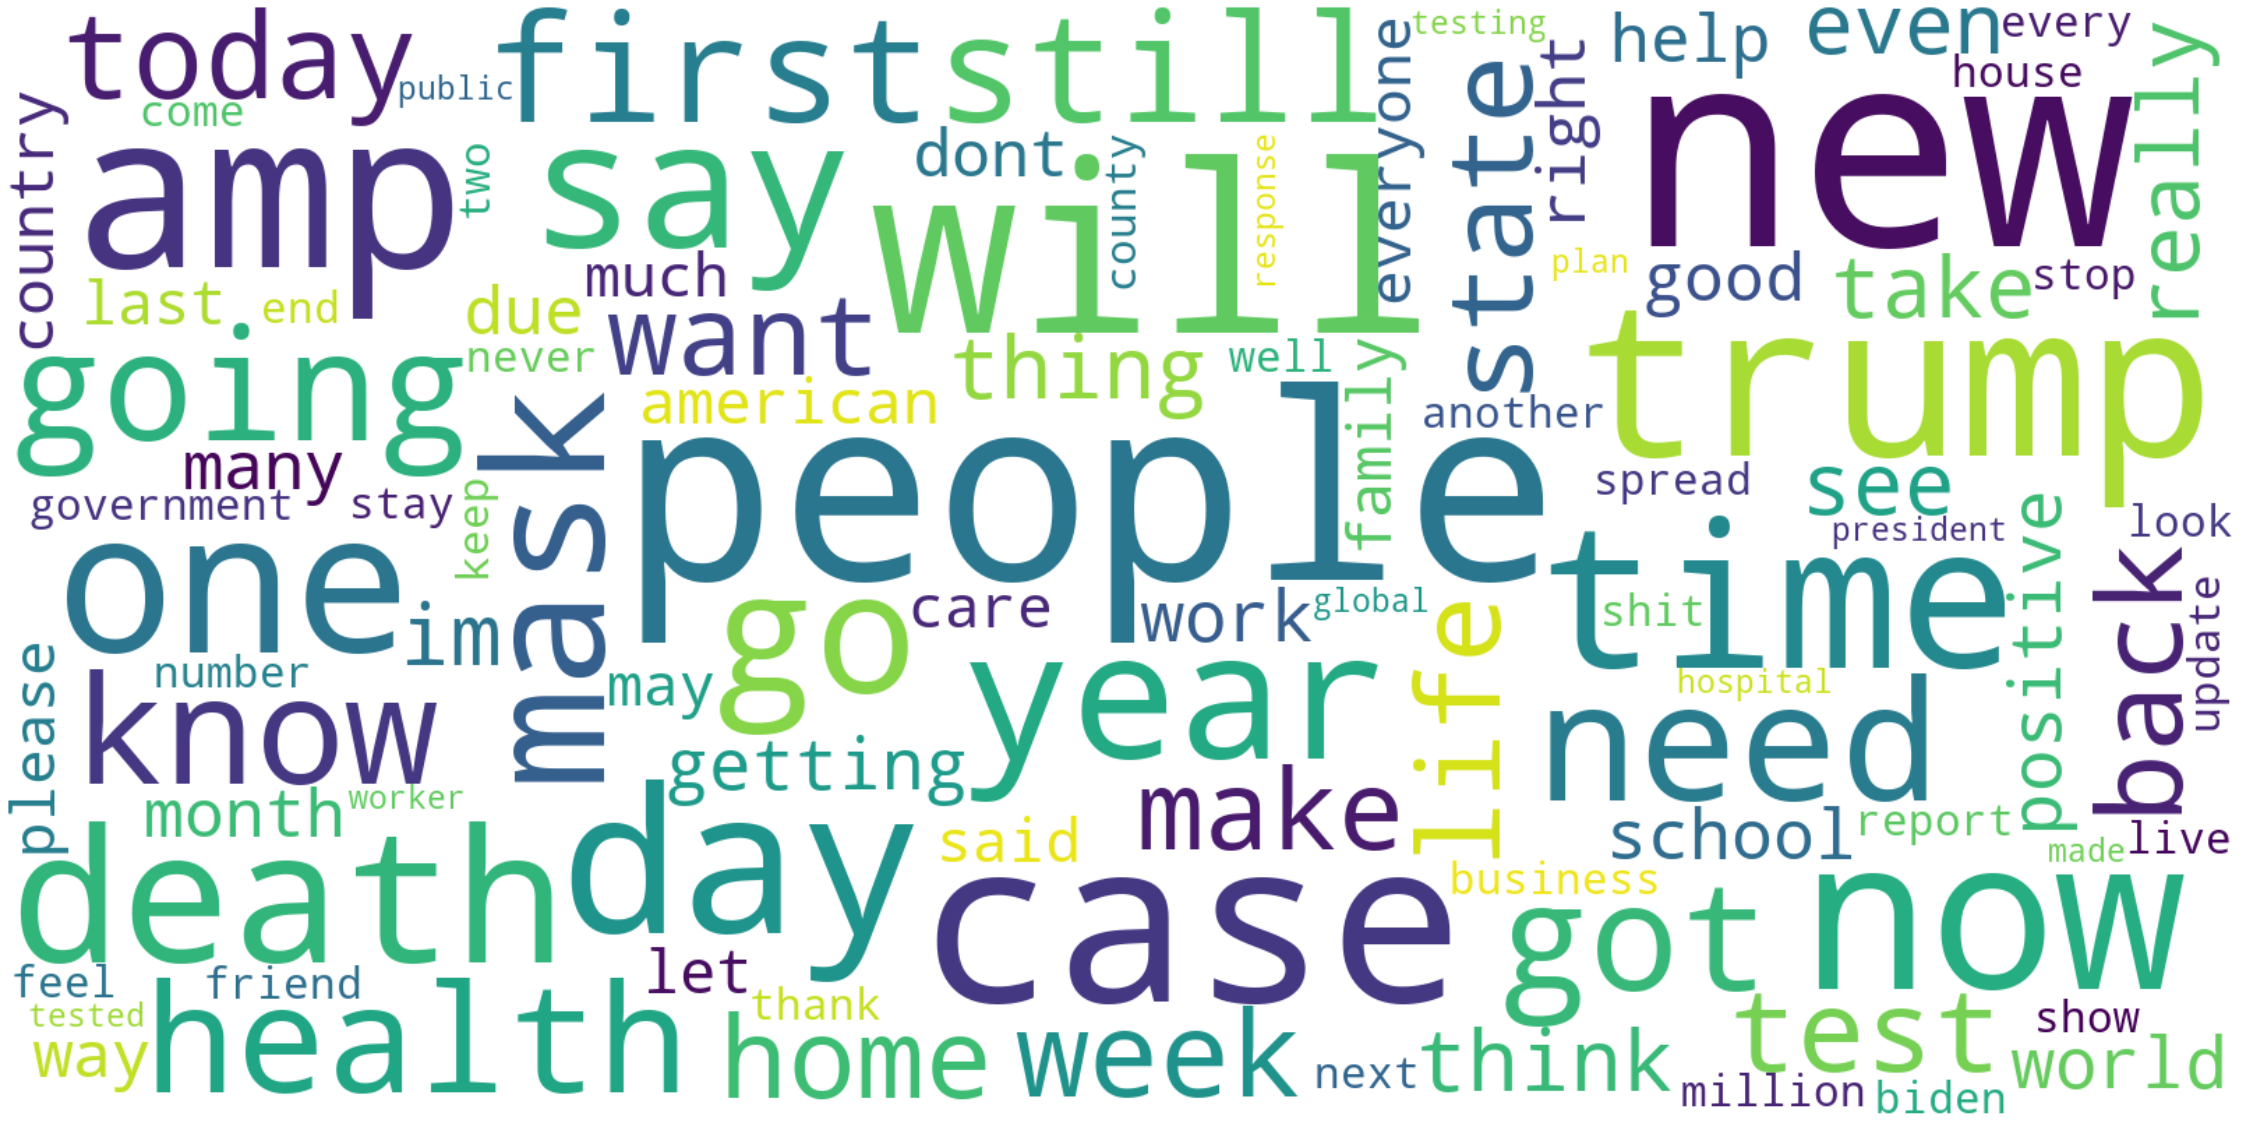

In [153]:
# Word Cloud after lemmatization
string_lem = df['text_lem'].apply(lambda x: " ".join(x))
string_lem = pd.Series(string_lem).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_lem)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Bigrams and Trigrams

In [154]:
def create_ngram(tweets, n=2):
    if n==2:
        terms = [list(bigrams(tweet)) for tweet in tweets]
        colname = 'bigram'
    elif n==3:
        terms = [list(everygrams(tweet, 3, 3)) for tweet in tweets]
        colname = 'trigram'
    else: 
        print("Invalid n")
        return 0

    # Flatten list of bigrams in clean tweets
    ngrams = list(itertools.chain(*terms))
    # Create counter of words in clean bigrams
    ngram_counts = collections.Counter(ngrams)
    # DataFrame from the counter
    ngram_df = pd.DataFrame(ngram_counts.most_common(25),columns=[colname, 'count'])
    return ngram_df

In [155]:
bigram_df = create_ngram(df['text_stem'], n=2)
trigram_df = create_ngram(df['text_stem'], n=3)

Text(0.5, 1.0, '25 most frequent bigrams')

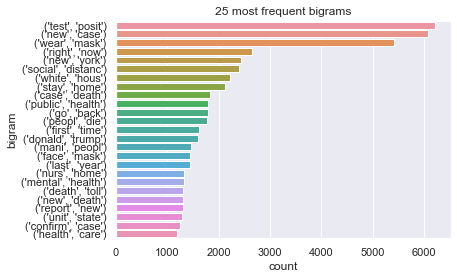

In [156]:
sns.barplot(x=bigram_df['count'], y=bigram_df['bigram']).set_title('25 most frequent bigrams')

Text(0.5, 1.0, '25 most frequent trigrams')

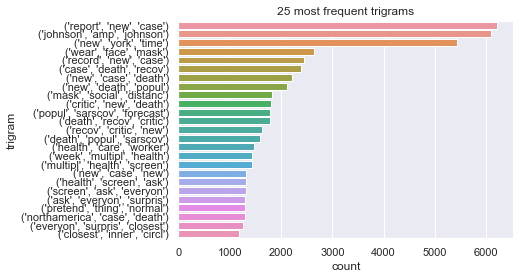

In [157]:
sns.barplot(x=bigram_df['count'], y=trigram_df['trigram']).set_title('25 most frequent trigrams')

#### Text Networks (work in progress)

In [159]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

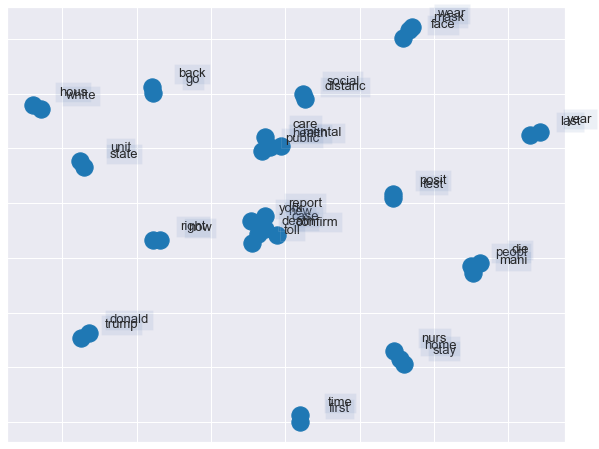

In [160]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(alpha=0.1),
            horizontalalignment='center', fontsize=13)
    
plt.show()

#### Emojis

In [ ]:
def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])
tweets_df['emojis'] = tweets_df['text'].apply(lambda x: extract_emojis(x))

### 5. Saving the output file

In [171]:
# Adding cleaned text to initial twitter df
tweets_df['text_stem'] = df['text_stem']

In [174]:
tweets_df.to_csv('../data/covid19_tweets_cleaned.csv', index=False)